<a href="https://colab.research.google.com/github/Karthick47v2/mock-buddy/blob/main/300w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs

In [1]:
import glob
import pandas as pd
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from itertools import chain
import os

## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Extract dataset

In [ ]:
# afw
!mkdir afw
!unzip /content/gdrive/MyDrive/300w/afw.zip -d afw/

# # ibug
# !mkdir ibug
# !unzip /content/gdrive/MyDrive/300w/ibug.zip -d ibug/

# # helen
# !mkdir helen
# !unzip /content/gdrive/MyDrive/300w/helen.zip -d helen/

# # lfpw
# !mkdir lfpw
# !unzip /content/gdrive/MyDrive/300w/lfpw.zip -d lfpw/

# bounding box region
!mkdir bb
!unzip /content/gdrive/MyDrive/300w/bounding_boxes.zip -d bb/

## Read data

In [6]:
def read_mat(filename):
  mat = scipy.io.loadmat(f"bb/Bounding Boxes/{filename}.mat")
  if filename == 'bounding_boxes_ibug':
    return mat['bounding_boxes'][0][0:135]
  return mat['bounding_boxes'][0]

def read_pts(filepath):
  return np.loadtxt(filepath, comments=("version:", "n_points:", "{", "}"))

def get_lm(dataset, img_name):
  return list(map(lambda x: read_pts(f"{dataset}/{x.split('.')[0]}.pts"), img_name))

def mat_to_pd(filename, dataset):
  mat = read_mat(filename)
  path, name, bb = zip(*[(f"/content/{dataset}/{x['imgName'][0][0][0]}", x['imgName'][0][0][0], 
                          x['bb_ground_truth'][0][0][0]) for x in mat])

  return pd.DataFrame({'path': path, 'name': name, 'bb': bb, 'lm': get_lm(dataset, name)})

afw_pd = mat_to_pd('bounding_boxes_afw', 'afw')
# ibug_pd = mat_to_pd('bounding_boxes_ibug', 'ibug')
# helen_train_pd = mat_to_pd('bounding_boxes_helen_trainset', 'helen/trainset')
# helen_test_pd = mat_to_pd('bounding_boxes_helen_testset', 'helen/testset')
# lfpw_train_pd = mat_to_pd('bounding_boxes_lfpw_trainset', 'lfpw/trainset')
# lfpw_test_pd = mat_to_pd('bounding_boxes_lfpw_testset', 'lfpw/testset')

# helen_pd = pd.concat([helen_train_pd, helen_test_pd], axis=0)
# lfpw_pd = pd.concat([lfpw_train_pd, lfpw_test_pd], axis=0)

In [ ]:
afw_pd

In [ ]:
ibug_pd

In [ ]:
helen_train_pd

In [ ]:
helen_test_pd

In [ ]:
lfpw_train_pd

In [ ]:
lfpw_test_pd

Length of AFW - 337

Length of iBug - 135

Length of helen (train+test) - 2000 + 330

Length of LFPW (train+test - 881 + 224


### Visualize annotated data

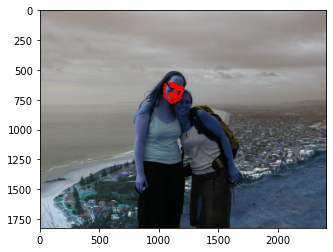

In [ ]:
# AFW
sample_idx = 2
img = cv2.imread(afw_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(afw_pd['lm'][sample_idx][:,0], afw_pd['lm'][sample_idx][:,1], s=3, c='r')

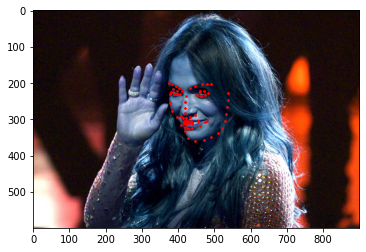

In [ ]:
# iBug
img = cv2.imread(ibug_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(ibug_pd['lm'][sample_idx][:,0], ibug_pd['lm'][sample_idx][:,1], s=3, c='r')

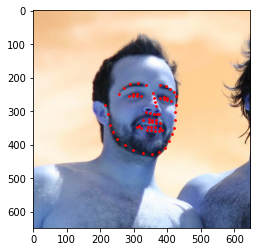

In [ ]:
# helen
img = cv2.imread(helen_train_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(helen_train_pd['lm'][sample_idx][:,0], helen_train_pd['lm'][sample_idx][:,1], s=3, c='r')

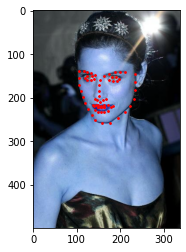

In [ ]:
# lfpw
img = cv2.imread(lfpw_train_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(lfpw_train_pd['lm'][sample_idx][:,0], lfpw_train_pd['lm'][sample_idx][:,1], s=3, c='r')

### Histogram of image dimensions (after crpped)

(array([ 59., 132., 113.,  27.,   6.]),
 array([ 67.548602 , 138.9382592, 210.3279164, 281.7175736, 353.1072308,
        424.496888 ]),
 <a list of 5 Patch objects>)

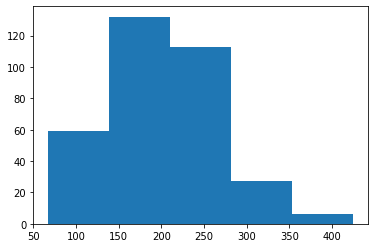

In [ ]:
## AFW
x1,y1,x2,y2= zip(*afw_pd.loc[:,'bb'])

plt.hist(list(map(lambda i, j: i - j, x2, x1)), bins=5)
plt.show()

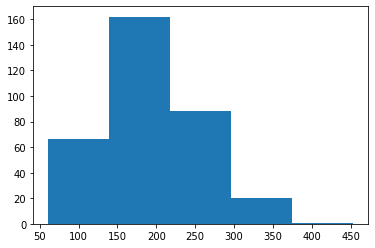

In [ ]:
plt.hist(list(map(lambda i, j: i - j, y2, y1)), bins=5)
plt.show()

(array([96., 32.,  6.,  0.,  1.]),
 array([  41.988297 ,  259.2702006,  476.5521042,  693.8340078,
         911.1159114, 1128.397815 ]),
 <a list of 5 Patch objects>)

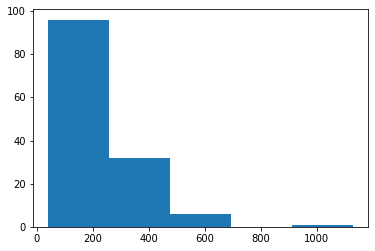

In [ ]:
## iBug
x1,y1,x2,y2= zip(*ibug_pd.loc[:,'bb'])

plt.hist(list(map(lambda i, j: i - j, x2, x1)), bins=5)
plt.show()

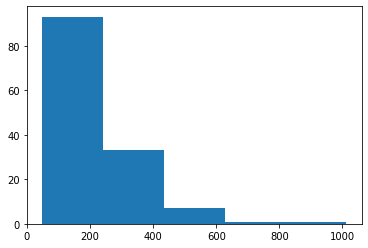

In [ ]:
plt.hist(list(map(lambda i, j: i - j, y2, y1)), bins=5)
plt.show()

## Data preprocessing

since most lie under 200 resize all to 192x192

Crop image and adjust landmarks then save to **respective** folder

In [7]:
img_size = 192

if not os.path.exists('afw_cropped'):
  os.mkdir('afw_cropped')

# if not os.path.exists('ibug_cropped'):
#   os.mkdir('ibug_cropped')

# if not os.path.exists('helen_train_cropped'):
#   os.mkdir('helen_train_cropped')

# if not os.path.exists('helen_test_cropped'):
#   os.mkdir('helen_test_cropped')

# if not os.path.exists('lfpw_train_cropped'):
#   os.mkdir('lfpw_train_cropped')

# if not os.path.exists('lfpw_test_cropped'):
#   os.mkdir('lfpw_test_cropped')

def resize_w_pad(img, lm, req_size):
  original_shape = (img.shape[1], img.shape[0])
  ratio = float(max(req_size))/max(original_shape)
  new_size = [int(x*ratio) for x in original_shape]
  img = cv2.resize(img, tuple(new_size))
  delta_w, delta_h = req_size[0] - new_size[0], req_size[1] - new_size[1]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)
  lm *= [float(new_size[0]/original_shape[0]), float(new_size[1]/original_shape[1])]
  lm += [left, top]
  lm = np.clip(lm,0,req_size[0])
  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))
  return img, lm

def preprocess_data(row, dataset):
  un_img = cv2.imread(row['path'])
  x1,y1,x2,y2 = row['bb']
  #crop
  c_img = un_img[int(y1-1):int(y2+1), int(x1-1):int(x2+1)]
  c_lm = row['lm'] - [x1,y1]
  #resize_with_padding
  resized_img, resized_lm = resize_w_pad(c_img, c_lm, (img_size,img_size))

  cv2.imwrite(f"{dataset}_cropped/{row['name']}" , resized_img)
  return resized_lm.ravel()

def generate_df(df, name):
  lms = list(map(lambda x: preprocess_data(x[1], name), df.iterrows()))

  # dataframe for image generator
  return pd.DataFrame({'path': f"{name}_cropped/" + df['name'].values, **{f"{i}": [lm[i] for lm in lms] for i in range(136)}})

afw_df = generate_df(afw_pd, 'afw')
# ibug_df = generate_df(ibug_pd, 'ibug')
# helen_train_df = generate_df(helen_train_pd, 'helen_train')
# helen_test_df = generate_df(helen_test_pd, 'helen_test')
# lfpw_train_df = generate_df(lfpw_train_pd, 'lfpw_train')
# lfpw_test_df = generate_df(lfpw_test_pd, 'lfpw_test')

# con_df = pd.concat([afw_df,ibug_df, helen_train_df, helen_test_df, lfpw_train_df, lfpw_test_df], axis=0)
con_df = afw_df #########################
con_df.to_csv('train.csv', index=False)

## Sample

In [8]:
sample_idx = 124
def crop_(path, box, name, bb, lm):
  un_img = cv2.imread(path)
  x1,y1,x2,y2 = box

  c_img = un_img[int(y1-1):int(y2+1), int(x1-1):int(x2+1)]
  c_lm = lm - [x1,y1]
  return resize_w_pad(c_img, c_lm, (img_size,img_size))

cropped_img, lms = crop_(afw_pd['path'][sample_idx],afw_pd['bb'][sample_idx],afw_pd['name'][sample_idx], afw_pd['bb'][sample_idx], afw_pd['lm'][sample_idx])
lms = lms.ravel()

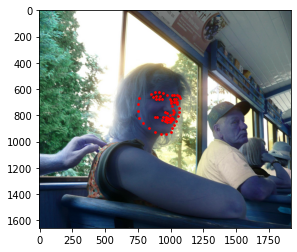

In [9]:
## AFW
img = cv2.imread(afw_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(afw_pd['lm'][sample_idx][:,0], afw_pd['lm'][sample_idx][:,1], s=3, c='r')

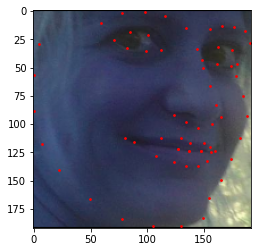

In [10]:
plt.imshow(cropped_img)
plt.scatter(lms[0:136:2],lms[1:136:2], s=3, c='r')

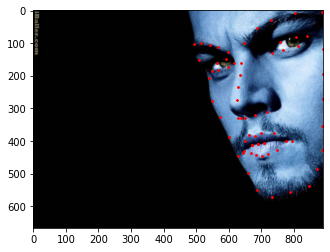

In [ ]:
## iBug

cropped_img, lms = crop_(ibug_pd['path'][sample_idx],ibug_pd['bb'][sample_idx],ibug_pd['name'][sample_idx], ibug_pd['bb'][sample_idx], ibug_pd['lm'][sample_idx])
lms = lms.ravel()

img = cv2.imread(ibug_pd['path'][sample_idx])
plt.imshow(img)
plt.scatter(ibug_pd['lm'][sample_idx][:,0], ibug_pd['lm'][sample_idx][:,1], s=3, c='r')

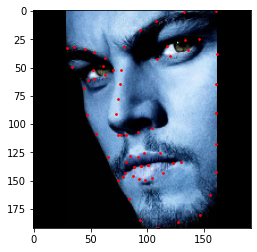

In [ ]:
plt.imshow(cropped_img)
plt.scatter(lms[0:136:2],lms[1:136:2], s=3, c='r')

In [ ]:
# check csv
c_df = pd.read_csv('train.csv')
c_df.head()

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,afw_cropped/1051618982_1.jpg,0.000000,34.007611,1.152939,59.554963,4.273874,85.894905,7.334143,110.559534,17.712759,...,101.571799,120.948836,127.513207,119.006910,101.571799,120.948836,91.760207,120.644430,81.865553,120.398791
1,afw_cropped/111076519_1.jpg,4.068649,32.399614,0.576591,57.581402,0.000000,84.087294,2.206496,108.423745,10.649447,...,114.143973,119.676863,136.310244,123.701356,111.852503,136.924835,97.836465,136.916312,84.499297,133.475341
2,afw_cropped/111076519_2.jpg,14.298346,12.922758,8.683190,39.628403,1.983458,66.367020,0.000000,92.489026,5.092092,...,116.612183,119.950632,133.292889,127.849968,107.257176,137.853354,93.470505,135.913935,82.027711,131.323412
3,afw_cropped/1130084326_1.jpg,4.471238,53.505021,1.681149,75.341510,0.000000,94.679833,3.319663,115.660975,9.045553,...,42.795424,122.889539,70.810764,124.524874,42.795424,122.889539,35.057526,122.501327,29.637588,121.923194
4,afw_cropped/1130084326_2.jpg,0.000000,32.084973,0.134263,59.102249,1.691001,84.023820,6.233328,106.461406,16.546198,...,142.699319,127.934853,151.006485,126.066795,142.699319,127.934853,132.187373,128.463394,121.722217,128.121547


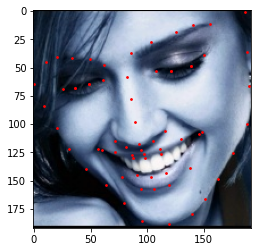

In [ ]:
sample_idx = 359
img = cv2.imread(c_df['path'][sample_idx])
plt.imshow(img)
plt.scatter(c_df.iloc[sample_idx, 1:137:2] * img_size ,c_df.iloc[sample_idx, 2:137:2] * img_size, s=3, c='r')

## Data augmentation

In [12]:
# randomly picking 50 % of train data to create each augmentations 
random_flip_images = np.random.choice(np.arange(afw_df.shape[0]), size=int(afw_df.shape[0] * 0.5), replace=False)

In [15]:
if not os.path.exists('afw_cropped_aug'):
  os.mkdir('afw_cropped_aug')

# flipping horizontally (both frame and keypoint)
def horizontal_flip(df):
  lis = []
  lin = []

  for idx, row in df.iterrows():
    un_img = cv2.imread(row['path'])
    flipped_img = cv2.flip(un_img, 1)
    cv2.imwrite(f"afw_cropped_aug/A{idx}.jpg" , flipped_img)     
    l = row[1:137:1]
    l[0:136:2] = img_size - l[0:136:2]
    l = np.clip(l,0,img_size)
    lis.append(l)
    lin.append(f"afw_cropped_aug/A{idx}.jpg")

  return lin, lis

afw_lin, afw_lis = horizontal_flip(afw_df.iloc[random_flip_images])


In [16]:
afw_aug_df = pd.DataFrame({'path': afw_lin, **{f"{i}": [lm[i] for lm in afw_lis] for i in range(136)} })

In [17]:
con_df = pd.concat([con_df,afw_aug_df], axis=0)
con_df.to_csv('train.csv', index=False)

In [19]:
pd.read_csv('train.csv')

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,afw_cropped/1051618982_1.jpg,0.000000,34.007611,1.152939,59.554963,4.273874,85.894905,7.334143,110.559534,17.712759,...,101.571799,120.948836,127.513207,119.006910,101.571799,120.948836,91.760207,120.644430,81.865553,120.398791
1,afw_cropped/111076519_1.jpg,4.068649,32.399614,0.576591,57.581402,0.000000,84.087294,2.206496,108.423745,10.649447,...,114.143973,119.676863,136.310244,123.701356,111.852503,136.924835,97.836465,136.916312,84.499297,133.475341
2,afw_cropped/111076519_2.jpg,14.298346,12.922758,8.683190,39.628403,1.983458,66.367020,0.000000,92.489026,5.092092,...,116.612183,119.950632,133.292889,127.849968,107.257176,137.853354,93.470505,135.913935,82.027711,131.323412
3,afw_cropped/1130084326_1.jpg,4.471238,53.505021,1.681149,75.341510,0.000000,94.679833,3.319663,115.660975,9.045553,...,42.795424,122.889539,70.810764,124.524874,42.795424,122.889539,35.057526,122.501327,29.637588,121.923194
4,afw_cropped/1130084326_2.jpg,0.000000,32.084973,0.134263,59.102249,1.691001,84.023820,6.233328,106.461406,16.546198,...,142.699319,127.934853,151.006485,126.066795,142.699319,127.934853,132.187373,128.463394,121.722217,128.121547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,afw_cropped_aug/A171.jpg,192.000000,9.000000,191.475564,44.012021,190.767179,66.783176,183.808085,87.388063,178.675263,...,120.246195,141.445209,93.541240,143.747158,120.246195,141.445209,132.492218,141.473761,142.923743,138.935191
501,afw_cropped_aug/A266.jpg,192.000000,53.207031,185.193299,77.556242,178.072425,101.050532,170.467790,125.737397,155.564158,...,45.156493,120.157246,35.624884,119.235106,45.156493,120.157246,53.501098,121.891393,61.919820,122.958746
502,afw_cropped_aug/A132.jpg,188.328288,32.484488,189.323151,61.179321,192.000000,92.057189,190.202934,122.444238,183.934290,...,105.720000,118.623851,90.130161,120.739431,105.720000,118.623851,114.791016,118.110217,122.782360,118.108183
503,afw_cropped_aug/A178.jpg,186.326827,44.054874,186.958418,64.457006,183.678902,84.444701,172.192183,106.807219,158.751878,...,101.033591,110.565608,72.609041,108.244250,96.043991,130.056058,107.738706,132.674614,118.151370,131.156528


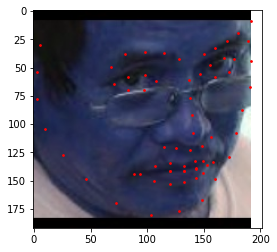

In [22]:
dd = pd.read_csv('train.csv')
sample_idx = 500
img = cv2.imread(dd['path'][sample_idx])
plt.imshow(img)
plt.scatter(dd.iloc[sample_idx, 1:137:2] ,dd.iloc[sample_idx, 2:137:2], s=3, c='r')

## Save to GDrive

In [33]:
!mv afw_cropped afw_cropped_aug train.csv /content/gdrive/MyDrive/300cw/

In [ ]:
# !mv ibug_cropped afw_cropped helen_train_cropped helen_test_cropped lfpw_train_cropped lfpw_test_cropped train.csv /content/gdrive/MyDrive/300cw/

In [ ]:
!zip -r 300.zip gdrive/MyDrive/300cw 

In [35]:
!mv 300.zip /content/gdrive/MyDrive/300cw/